<h1><center>Τεχνικές Εξόρυξης Δεδομένων - 1η Εργασία
</br>ΑΝΤΡΕΪ-ΑΝΤΡΙΑΝ ΠΡΕΝΤΑ - 1115202000263
</center></h1>


In [496]:
import pandas as pd
import matplotlib.pyplot as plt

---
##1.


In [497]:
df= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/marketing_campaign.csv', sep='\t', index_col=['ID'])

Μετατροπή της στήλης **Dt_Customer** σε **DateTime**

In [498]:
df['Dt_Customer']= pd.to_datetime(df['Dt_Customer'], dayfirst= True)

Διαγραφή γραμμών όπου υπάρχει έλλειψη δεδομένων

In [499]:
df= df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 5524 to 9405
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Year_Birth           2216 non-null   int64         
 1   Education            2216 non-null   object        
 2   Marital_Status       2216 non-null   object        
 3   Income               2216 non-null   float64       
 4   Kidhome              2216 non-null   int64         
 5   Teenhome             2216 non-null   int64         
 6   Dt_Customer          2216 non-null   datetime64[ns]
 7   Recency              2216 non-null   int64         
 8   MntWines             2216 non-null   int64         
 9   MntFruits            2216 non-null   int64         
 10  MntMeatProducts      2216 non-null   int64         
 11  MntFishProducts      2216 non-null   int64         
 12  MntSweetProducts     2216 non-null   int64         
 13  MntGoldProds         2216 non-

**Η κωδικοποίηση του Marital_Status και Education σε αριθμητική τιμή γίνεται στο ζητούμενο 2 για λόγους διευκόλυνσης**

---
##2.

In [500]:
df['Marital_Status'].unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

In [501]:
df['Education'].unique()

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

In [502]:
df.loc[df['Marital_Status'] == 'Alone',['Marital_Status']]='Single'
df.loc[df['Marital_Status'] == 'Absurd',['Marital_Status']]='Single'
df.loc[df['Marital_Status'] == 'YOLO',['Marital_Status']]='Single'

Πααρουσίαση πλήθους τιμών με histogram

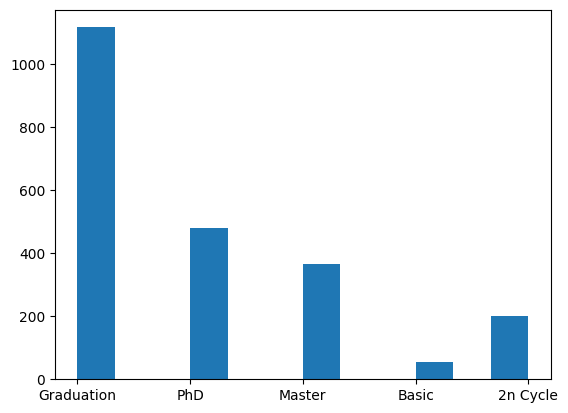

In [503]:
h= plt.hist(df['Education'], bins=12)

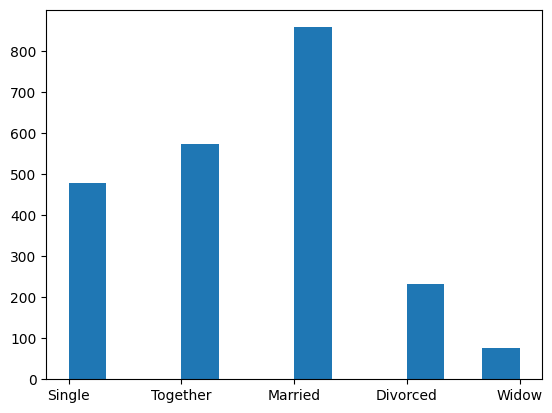

In [504]:
h= plt.hist(df['Marital_Status'], bins=12)

Αφού γίνουν τα histogram, μετατροπή κατηγορημάτων σε αριθμητική τιμή (ζητούμενο **1.**)

In [505]:
from sklearn.preprocessing import LabelEncoder

In [506]:
labelencoder = LabelEncoder()

In [507]:
df['Education_le'] = labelencoder.fit_transform(df['Education'])



*   0: 2nd Cycle
*   1: Basic
*   2: Graduation
*   3: Master
*   4: PhD



In [508]:
df['Marital_Status_le'] = labelencoder.fit_transform(df['Marital_Status'])



*   0: Divorced
*   1: Married
*   2: Single
*   3: Together
*   4: Widow



---
##3.

Α. \
  Αφού βρεθεί πρώτα η ημερομηνία στην οποία αναφέρεται η στήλη **Recency** (= από τη σημερινή ημερομηνία αφαιρούνται οι ημέρες 'Recency'), υπολογίζεται η διαφορά.

In [509]:
curr= pd.to_datetime('today')
df['Customer_For']= (curr - pd.to_timedelta(df['Recency'], unit='d')).sub(df['Dt_Customer']).dt.days

B.

In [510]:
df['Age']= curr.year - df['Year_Birth']

Γ. \
Από **MntWines** έως **MntGoldProds** sum ανά γραμμή

In [511]:
df['Spent']= df.iloc[:,9:15].sum(axis=1)

Δ.

In [512]:
df['Παιδιά']= df['Kidhome'] + df['Teenhome']

Ε.

Πελάτης (=1) + Παιδιά + **Marital_Status**

In [513]:
df['Family_Size']= 1 + df['Παιδιά'] + [0 if n == 0 or n == 2 or n == 4 else 1 for n in df['Marital_Status_le']]

Στ.

In [514]:
df['Is_Parent']= df['Παιδιά'] > 0

Z.

In [515]:
df['Living_With']= ['Alone' if n == 0 or n == 2 or n == 4 else 'Partner' for n in df['Marital_Status_le']]

H.

In [516]:
df['Age_Group']= ['21-30' if x >= 21 and x <= 30 else '31-40' if x <= 40 else '41-50' if x <= 50 else '51-60' if x <= 60 else '61-70' if x <= 70 else '71-80' if x<= 80 else '>80' for x in df['Age']]

---
##4.

**three-standard deviation** αρκεί για την ανίχνευση ακραίων τιμών για το συγκεκριμένο dataset

Ελέγχονται τα περισσότερα χαρακτηριστικά τα οποία δέχονται αριθμητικές τιμές σε μεγάλο εύρος

In [517]:
# Συνάρτηση που δέχεται λίστα με όλα τα χαρακτηριστικά που θα ελεγχθούν για ακραίες τιμές και επιστρέφει
# ένα σύνολο με όλα τα ID κάθε γραμμής όπου βρέθηκε ακραία τιμή

def outliers(columns: list) -> set:
  idx= set()          # αποφυγή διπλότυπων ID
  for col in columns:
    l= []
    m= df[col].mean()
    s= df[col].std()
    l.append(df[(df[col] > m + 3*s) | (df[col] < m - 3*s)].index)
    for i in l:
      for j in i:
        idx.add(j)
  
  return idx

In [518]:
# Τα χαρακτηριστικά που θα ελεγχθούν
cols= outliers(['Year_Birth', 'Income', 'Age', 'Spent', 'MntWines', 'MntFruits', 'MntMeatProducts',	'MntFishProducts',	'MntSweetProducts',	'MntGoldProds'])
print(len(cols),"rows found in total")

233 rows found in total


In [519]:
df= df.drop(labels= cols, axis=0)   # αφαίρεση γραμμών όπου βρέθηκε ακραία τιμή

---
##5.

In [520]:
df2= df.drop(['Marital_Status', 'Education', 'Dt_Customer', 'Is_Parent', 'Living_With',	'Age_Group'],axis=1)

In [521]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [522]:
df2=(df2-df2.mean())/df2.std()    # standardize

<Axes: >

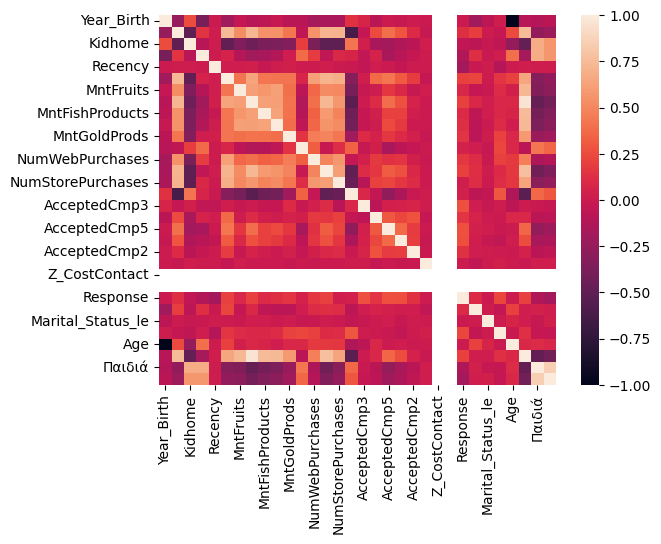

In [523]:
sns.heatmap(df2.corr())

---
##6.
<br/>

**Τα 10 ερωτήματα που έχουν επιλεχτεί:
1, 2 και από 5 έως 12**

1.

<Axes: >

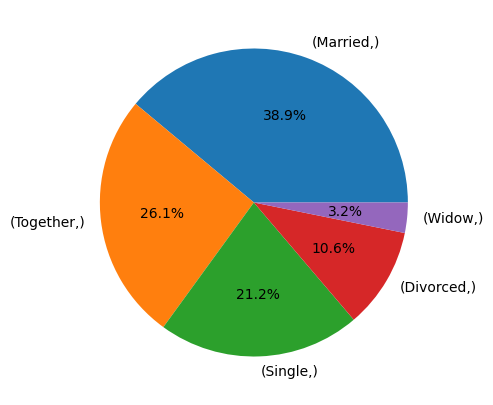

In [524]:
pd.DataFrame(df['Marital_Status']).value_counts().plot.pie(figsize=(5, 5), autopct='%1.1f%%')

2.

<Axes: >

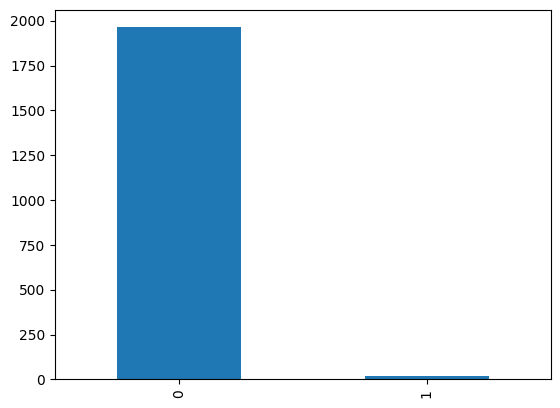

In [525]:
df['Complain'].value_counts().plot.bar()

5.

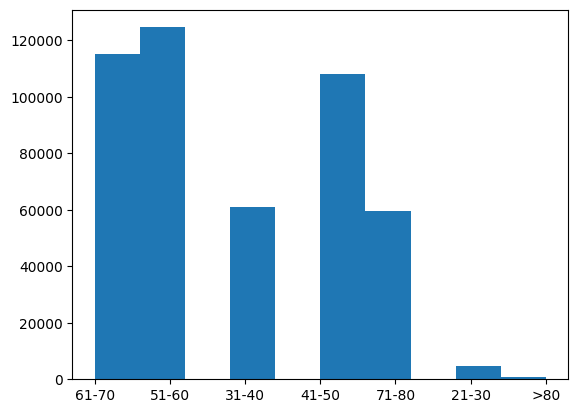

In [526]:
h= plt.hist(df.Age_Group, weights= df.Spent)

6.

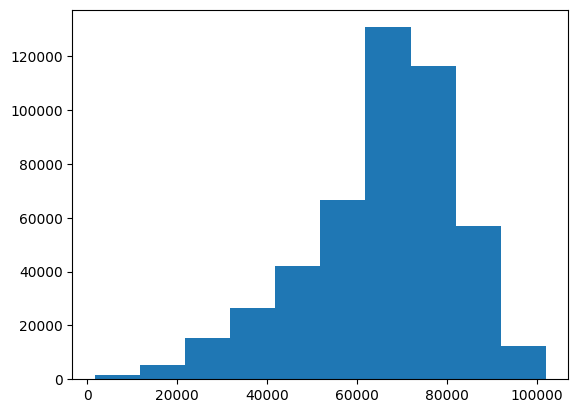

In [527]:
h= plt.hist(df.Income, weights= df.Spent)

7. (ο y άξονας **Income**: $n*10^{-3}$)

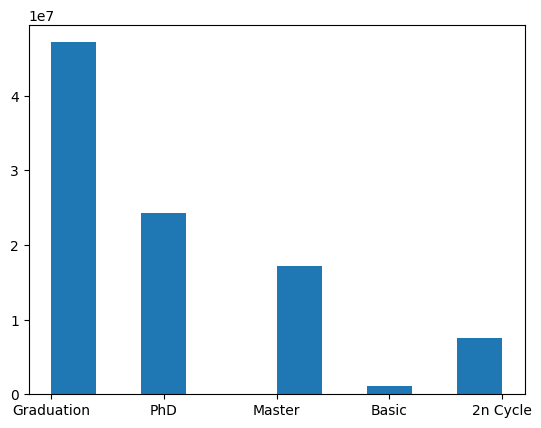

In [528]:
h= plt.hist(df.Education, weights= df.Income)

8.

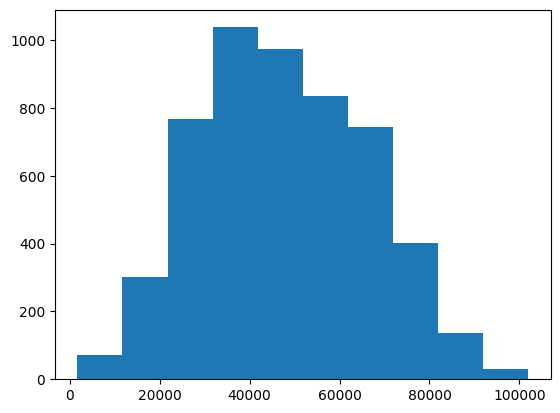

In [529]:
h= plt.hist(df.Income, weights= df.Family_Size)

9.

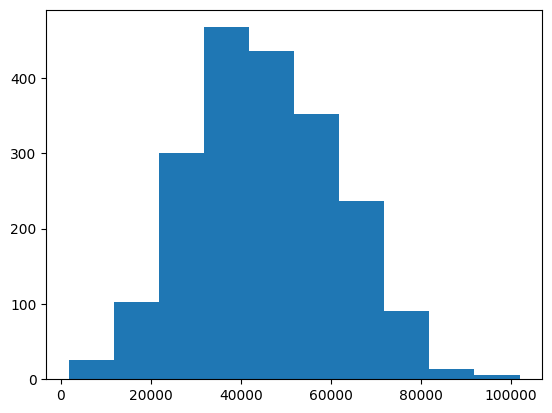

In [530]:
h= plt.hist(df.Income, weights= df.Παιδιά)

10.

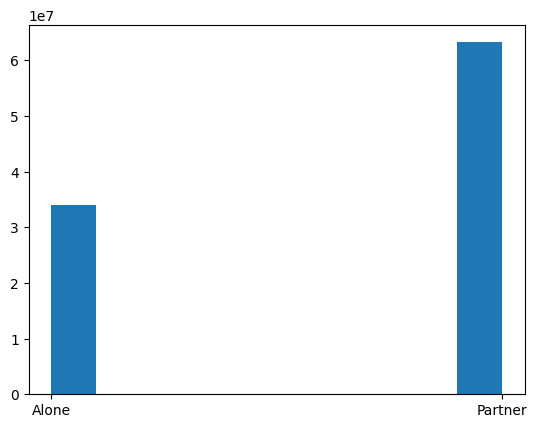

In [531]:
h= plt.hist(df.Living_With, weights= df.Income)

11.

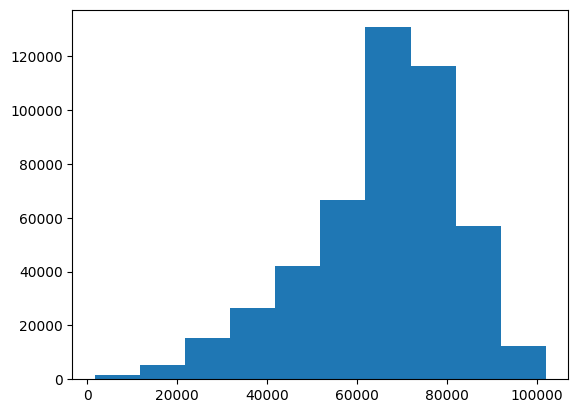

In [532]:
h= plt.hist(df.Income, weights= df.Spent)

12.

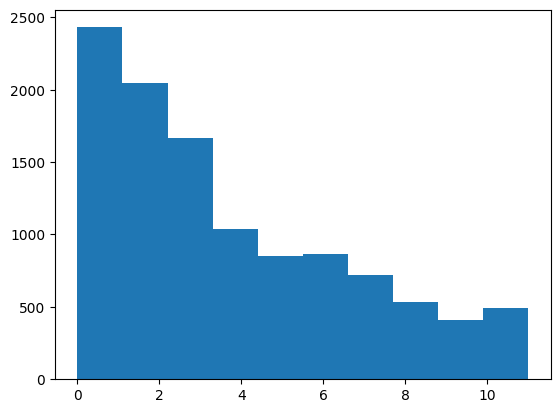

In [533]:
h= plt.hist(df.NumWebPurchases, weights= df.NumWebVisitsMonth)

---
##7.

Έχουμε ήδη τα **Education_le** και **Marital_Status_le**, οπότε μετατρέπεται μόνο η στήλη **Living_With**

Αφαιρούνται επίσης οι στήλες **Z_CostContact, Z_Revenue** αφού δεν αλλάζουν για κανέναν πελάτη.

In [534]:
df3= df.drop(['Education', 'Marital_Status', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Z_Revenue', 'Z_CostContact', 'Complain', 'Response', 'Age_Group', 'Dt_Customer'],axis=1)
df3['Living_With'] = labelencoder.fit_transform(df3['Living_With'])

In [535]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [536]:
scaled = StandardScaler().fit_transform(df3)  # Standardize

Μείωση της διάστασης κρατώντας **n_components** μεταβλητές

In [537]:
pca = PCA(n_components=3)
compon= pca.fit_transform(scaled)

In [538]:
df_pca= pd.DataFrame(data= compon, columns= ['c1', 'c2', 'c3'])

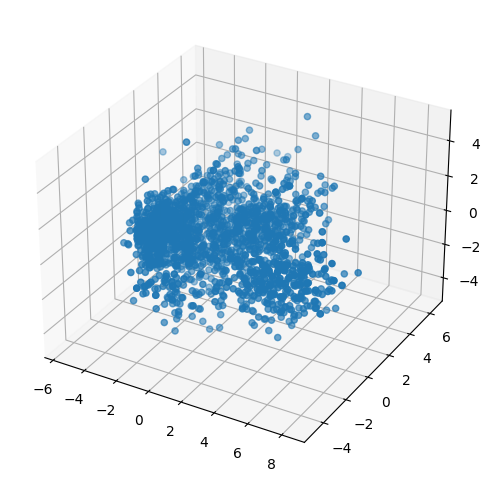

In [539]:
plt.figure(figsize= (6,6))
ax = plt.axes(projection = '3d')
ax.scatter(df_pca.c1, df_pca.c2, df_pca.c3)

---
##8.

In [540]:
from sklearn.cluster import KMeans

μέθοδος **elbow**

In [541]:
num_of_clust= range(1,10)
err= list()
for k in num_of_clust:
  km= KMeans(n_clusters= k, n_init= 10)
  km.fit(df_pca)
  err.append(km.inertia_)

In [542]:
err

[27260.425224222083,
 14604.311193719095,
 10804.208613811847,
 8400.07933363046,
 7377.631940433687,
 6586.572048737329,
 5870.4246125879545,
 5259.10792958647,
 4846.248005557209]

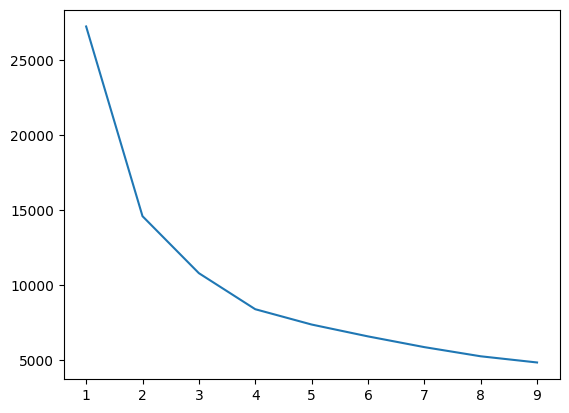

In [543]:
plt.plot(num_of_clust, err)

Σχηματίζεται elbow για n_clusters = 4, οπότε αυτός θα είναι ο αριθμός των συστάδων

In [544]:
km= KMeans(n_clusters= 4, n_init= 10)   # n_init= 10 (το οποίο είναι ίσο με την default τιμή) για αποφυγή error

In [545]:
df_pca['Cluster']= km.fit_predict(df_pca)

In [546]:
df_pca1= df_pca[df_pca.Cluster == 0]    # dataframe ανά cluster, ώστε να κάνουμε plot το κάθε cluster ξεχωριστά
df_pca2= df_pca[df_pca.Cluster == 1]
df_pca3= df_pca[df_pca.Cluster == 2]
df_pca4= df_pca[df_pca.Cluster == 3]

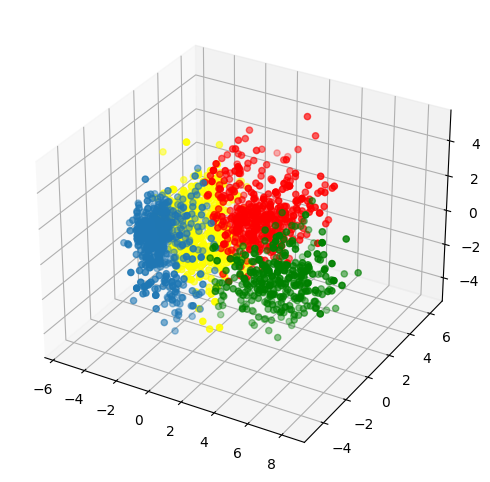

In [547]:
plt.figure(figsize= (6,6))
ax = plt.axes(projection = '3d')
ax.scatter(df_pca1.c1, df_pca1.c2, df_pca1.c3)
ax.scatter(df_pca2.c1, df_pca2.c2, df_pca2.c3, color= 'green')
ax.scatter(df_pca3.c1, df_pca3.c2, df_pca3.c3, color= 'red')
ax.scatter(df_pca4.c1, df_pca4.c2, df_pca4.c3, color= 'yellow')